### - Sobhan Moradian Daghigh
#### - 7/9/2022
### - DIP - HW05 - Q3

In [809]:
import numpy as np
import glob
import cv2
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression

In [2]:
def load_datas(folder_name):
    images = glob.glob('{}*.png'.format(folder_name))
    datas = []
    names = []
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        datas.append(img)
        names.append(image.split('\\')[-1][:-4])
    return datas, names

In [3]:
images, names = load_datas('./inputs/P3/')

In [4]:
names

['cart_1', 'cart_2']

In [70]:
def plotter(images, names=None, subplots=None, gray=False):
    if subplots is None:
        plt.figure(figsize=(15, 10))
        plt.imshow(images, cmap='gray') if gray else plt.imshow(images)
        plt.title(names)
        plt.axis('off')
    else:
        fig, ax = plt.subplots(subplots[0], subplots[1], figsize=(subplots[1] * 12, subplots[0] * 5))
        for i, (img, name, ax) in enumerate(zip(images, names, fig.axes)):
            ax.imshow(img, cmap='gray') if gray else ax.imshow(img)
            ax.set_title(name)
            ax.axis('off')
    plt.show()

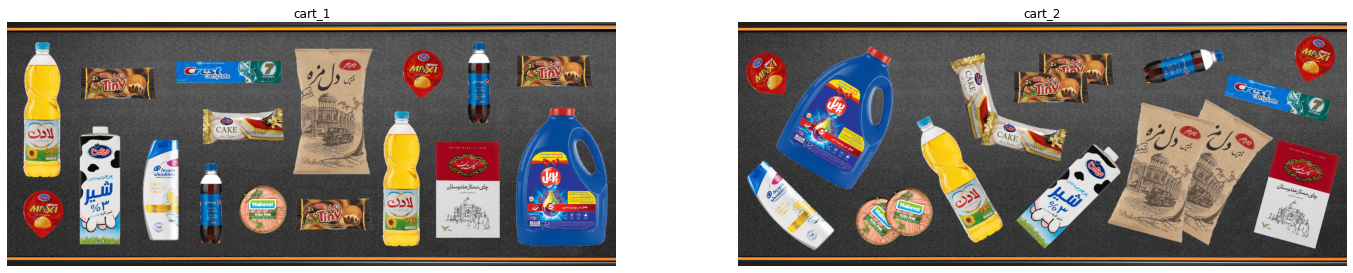

In [6]:
plotter(images, names, subplots=(1, 2))

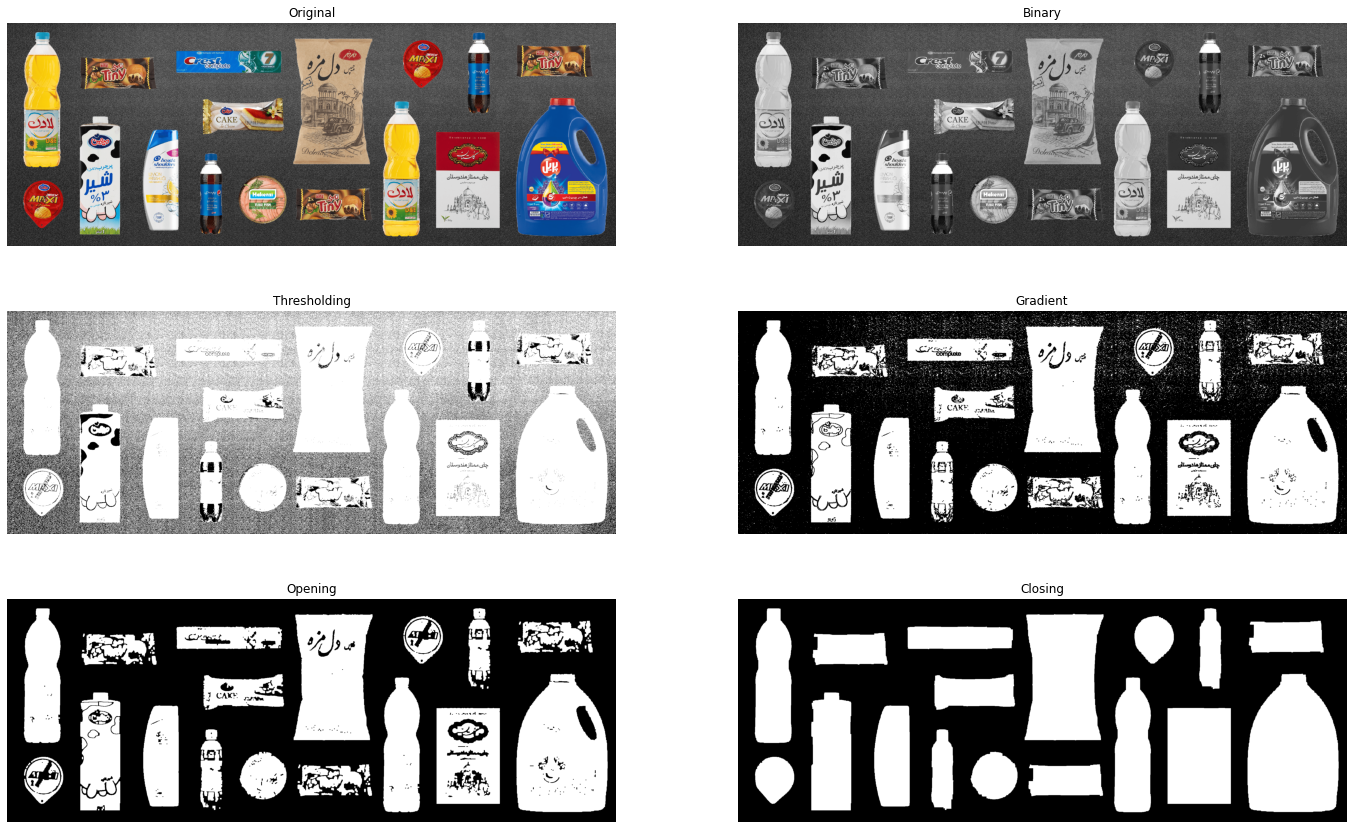

In [974]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 3))
org_img = images[0]
org_img = org_img[50:-50,]
binary = cv2.cvtColor(org_img, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(binary, 50, 255, cv2.THRESH_BINARY)


gradient1 = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
gradient1 = np.subtract(gradient1, np.ones(gradient1.shape, np.uint8))


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 7))
opening1 = cv2.morphologyEx(gradient1, cv2.MORPH_OPEN, kernel)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 41))

closing1 = cv2.morphologyEx(opening1, cv2.MORPH_CLOSE, kernel)
closing1 = np.multiply(np.subtract(closing1, 254), 255)


plotter([org_img, binary, thresh, gradient1, opening1, closing1], ['Original', 'Binary', 'Thresholding', 'Gradient', 'Opening', 'Closing'], subplots=(3, 2), gray=True)

### Part A.

In [729]:
contours, hierarchy = cv2.findContours(closing1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
total_cnt = len(contours)
print('The count of items on the conveyor belt:  {}'.format(total_cnt))

The count of items on the conveyor belt:  17


### Part B.

In [730]:
def get_gradient(img, kernel):
    gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    return gradient

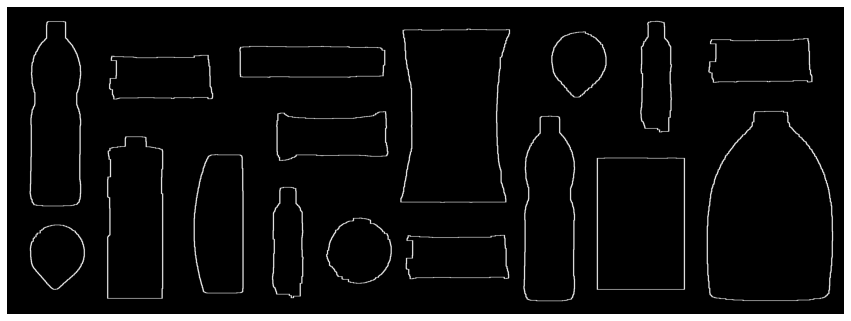

In [731]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 2))

gradient = get_gradient(closing1, kernel)
gradient = get_gradient(gradient, kernel)
plotter(gradient, gray=True)

In [732]:
items = {0: 'Tiny cake', 1: 'Maxi', 2: 'Makenzi', 3: 'Pepci', 4: 'Tea', 5: 'Shampoo', 6: 'Milk',
         7: 'Oil', 8: 'Mihan cake', 9: 'Peril', 10: 'Tiny cake', 11: 'Toothpaste', 12: 'Tiny cake',
         13: 'Maxi', 14: 'Chips', 15: 'Oil', 16: 'Pepci'}

In [733]:
result = {}
for key,value in items.items():
    if value not in result.values():
        result[key] = value
items = result
items

{0: 'Tiny cake',
 1: 'Maxi',
 2: 'Makenzi',
 3: 'Pepci',
 4: 'Tea',
 5: 'Shampoo',
 6: 'Milk',
 7: 'Oil',
 8: 'Mihan cake',
 9: 'Peril',
 11: 'Toothpaste',
 14: 'Chips'}

In [971]:
def find_objects(contours, item:(key, value), search_in_img, org_img, total_cnt):
    search_in_img_copy = search_in_img.copy()
    org_img_copy = org_img.copy()
    x_coors = []
    y_coors = []
    for coordinate in contours[item[0]]:
        x_coors.append(coordinate[0][0])
        y_coors.append(coordinate[0][1])

    x_min = min(x_coors)
    y_min = min(y_coors)

    x_coors = np.subtract(x_coors, x_min)
    y_coors = np.subtract(y_coors, y_min)

    x_max = max(x_coors)
    y_max = max(y_coors)

    blank = np.zeros((y_max + 1, x_max + 1), dtype=np.uint8)

    for x_coor, y_coor in zip(x_coors, y_coors):
        blank[y_coor, x_coor] = 255
    
#     plotter(blank, gray=True)
    
    res = cv2.matchTemplate(search_in_img_copy, blank, cv2.TM_CCORR_NORMED)
#     plotter(res, gray=True)
    threshold = .35
    
    loc = np.where(res >= threshold)
    w, h = blank.shape

    for pt in zip(*loc[::-1]):
        cv2.rectangle(org_img_copy, pt, (pt[0] + h, pt[1] + w), (0, 255, 0), 5)
        cv2.rectangle(search_in_img_copy, np.subtract(pt, [10, 10]), (pt[0] + h + 10, pt[1] + w + 10), 0, -1)    
    
    contours, hierarchy = cv2.findContours(search_in_img_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = total_cnt - len(contours)
    
    if cnt <= 0:
        
        search_in_img_copy = search_in_img.copy()
        org_img_copy = org_img.copy()
        
        threshold = .5
    
        loc = np.where(res >= threshold)
        w, h = blank.shape

        for pt in zip(*loc[::-1]):
            cv2.rectangle(org_img_copy, pt, (pt[0] + h, pt[1] + w), (0, 255, 0), 5)
            cv2.rectangle(search_in_img_copy, np.subtract(pt, [10, 10]), (pt[0] + h + 10, pt[1] + w + 10), 0, -1)
    
        contours, hierarchy = cv2.findContours(search_in_img_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt = total_cnt - len(contours)
        
    
    print('The count of   {:<12}:  {}'.format(item[1], cnt))
    
    return org_img_copy, cnt

The count of   Tiny cake   :  3
The count of   Maxi        :  2
The count of   Makenzi     :  1
The count of   Pepci       :  2
The count of   Tea         :  1
The count of   Shampoo     :  1
The count of   Milk        :  1
The count of   Oil         :  2
The count of   Mihan cake  :  1
The count of   Peril       :  1
The count of   Toothpaste  :  1
The count of   Chips       :  1


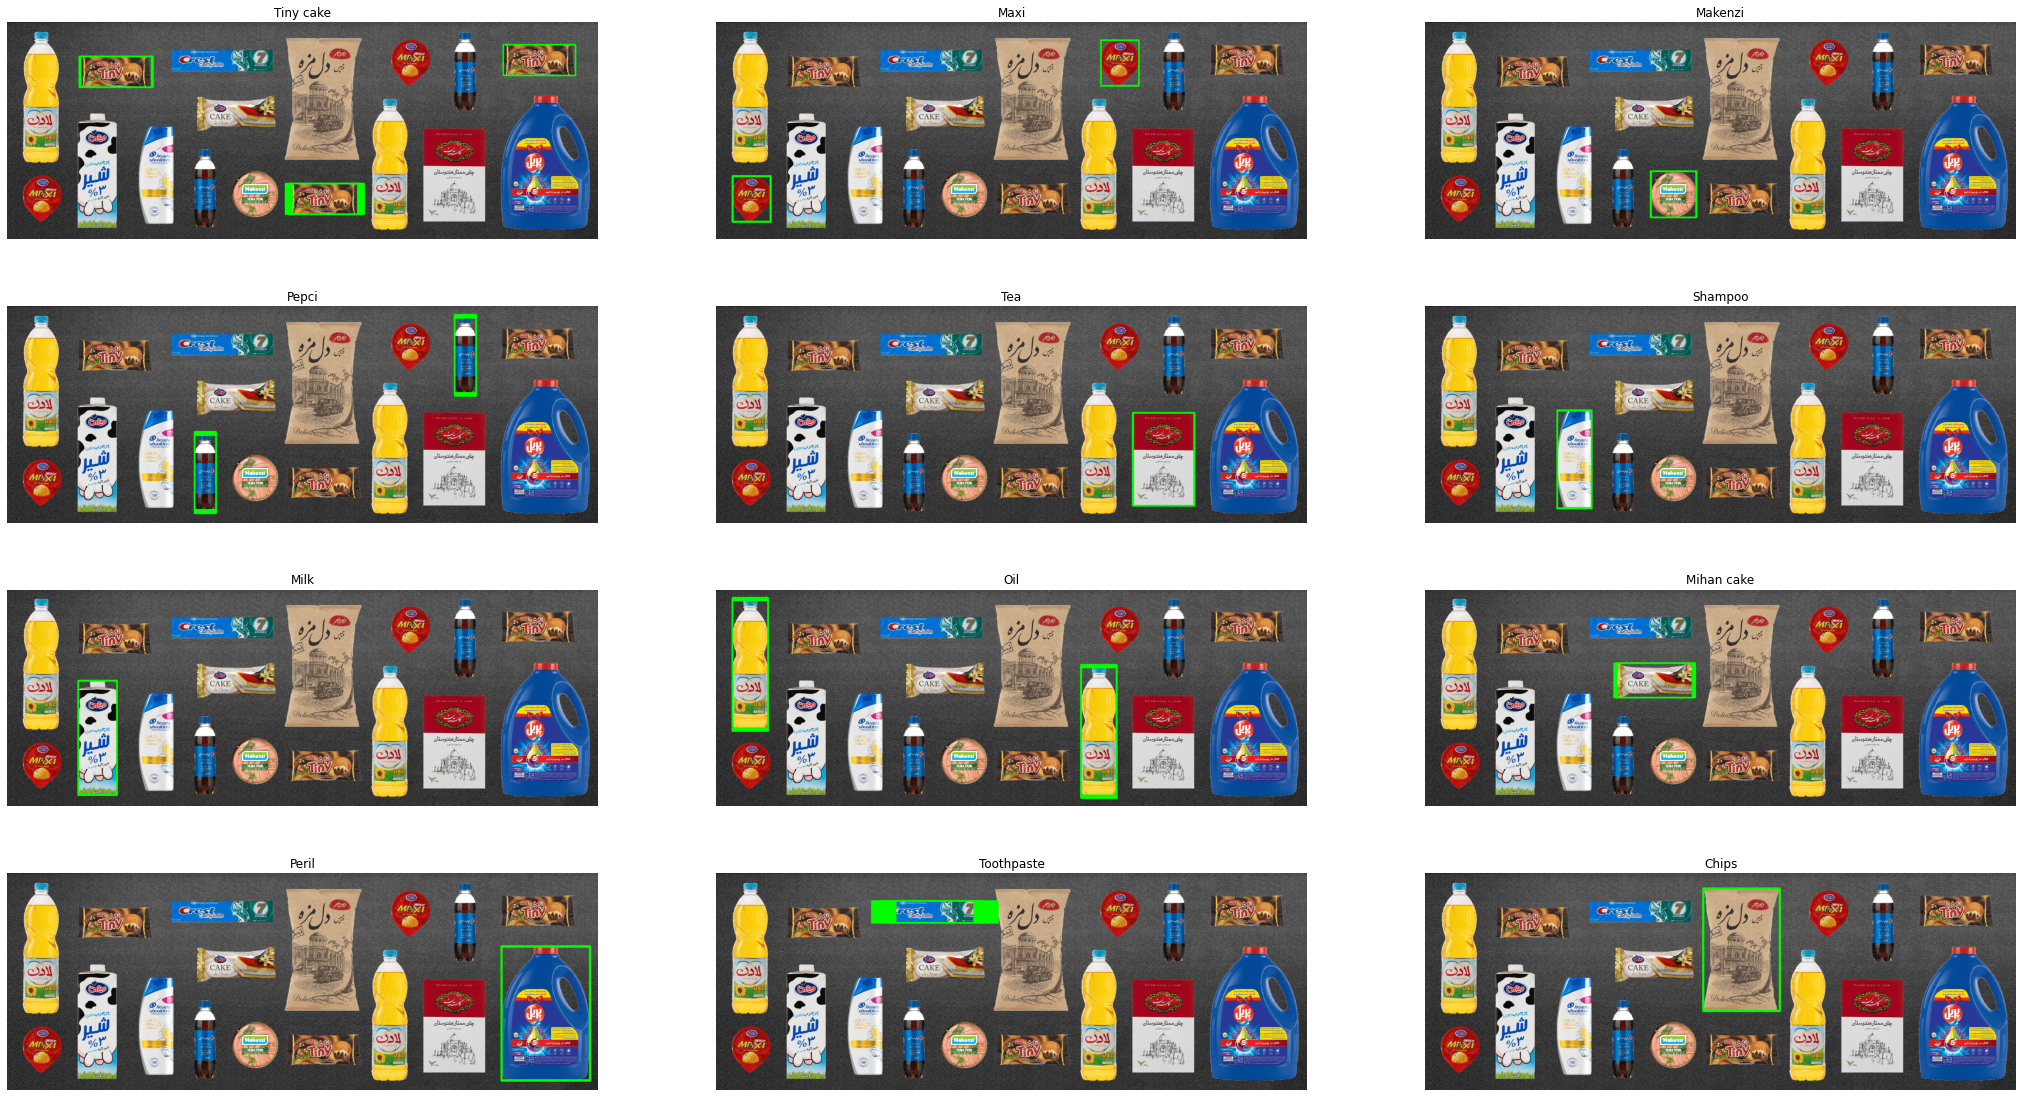

In [850]:
results = []
for key, value in zip(list(items.keys()), list(items.values())):
    results.append(find_objects(contours=contours, item=(key, value), search_in_img=gradient.copy(), org_img=org_img.copy(), total_cnt=total_cnt)[0])
plotter(results, names=items.values(), subplots=(4, 3))

### Part C.

The count of   Pepci       :  2
The count of   Milk        :  1
Total amount of money: 43000


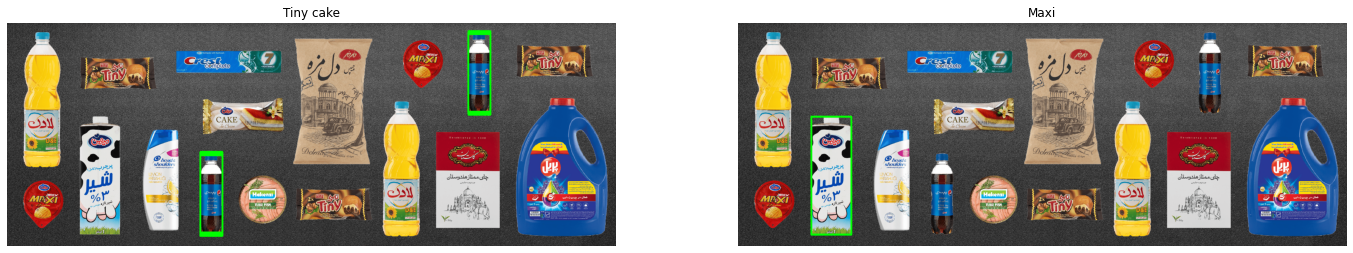

In [851]:
derinks = {'Milk': 30000, 'Pepci': 6500}
results = []
money = 0
for key, value in zip(list(items.keys()), list(items.values())):
    if value in list(derinks.keys()):
        img, cnt = find_objects(contours=contours, item=(key, value), search_in_img=gradient.copy(), org_img=org_img.copy(), total_cnt=total_cnt)
        money += (cnt * derinks.get(value))
        results.append(img)
print('Total amount of money: {}'.format(money))
plotter(results, names=items.values(), subplots=(1, 2))

### Part D.

The count of   Maxi        :  2
The count of   Milk        :  1
The count of   Mihan cake  :  1
Total number of items produced by Mihan: 4


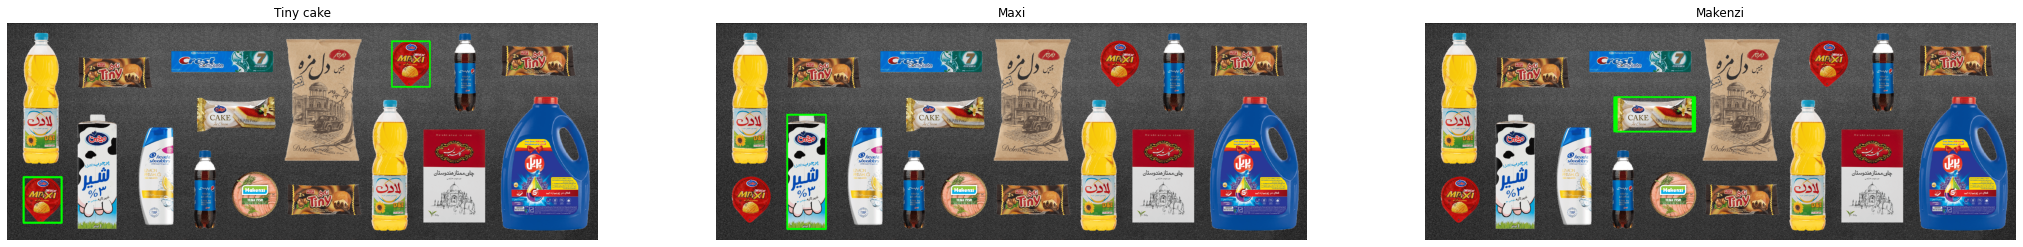

In [852]:
mihan_products = ['Maxi', 'Milk', 'Mihan cake']
results = []
cnts = 0
for key, value in zip(list(items.keys()), list(items.values())):
    if value in mihan_products:
        img, cnt = find_objects(contours=contours, item=(key, value), search_in_img=gradient.copy(), org_img=org_img.copy(), total_cnt=total_cnt)
        cnts += cnt
        results.append(img)
print('Total number of items produced by Mihan: {}'.format(cnts))
plotter(results, names=items.values(), subplots=(1, 3))

### Part E.

In [855]:
costs = {'Tiny cake': 5000, 'Maxi': 6000, 'Makenzi': 40000, 'Pepci': 6500, 'Tea': 144000, 'Shampoo': 139000,
           'Milk': 30000, 'Oil': 108000, 'Mihan cake': 8000, 'Peril': 83000, 'Toothpaste': 50000, 'Chips': 36000}
money = 0
for key, value in zip(list(items.keys()), list(items.values())):
    if value in list(costs.keys()):
        _, cnt = find_objects(contours=contours, item=(key, value), search_in_img=gradient.copy(), org_img=org_img.copy(), total_cnt=total_cnt)
        money += (cnt * costs.get(value))
print('Total amount of money: {}'.format(money))

The count of   Tiny cake   :  3
The count of   Maxi        :  2
The count of   Makenzi     :  1
The count of   Pepci       :  2
The count of   Tea         :  1
The count of   Shampoo     :  1
The count of   Milk        :  1
The count of   Oil         :  2
The count of   Mihan cake  :  1
The count of   Peril       :  1
The count of   Toothpaste  :  1
The count of   Chips       :  1
Total amount of money: 786000


### Part F.

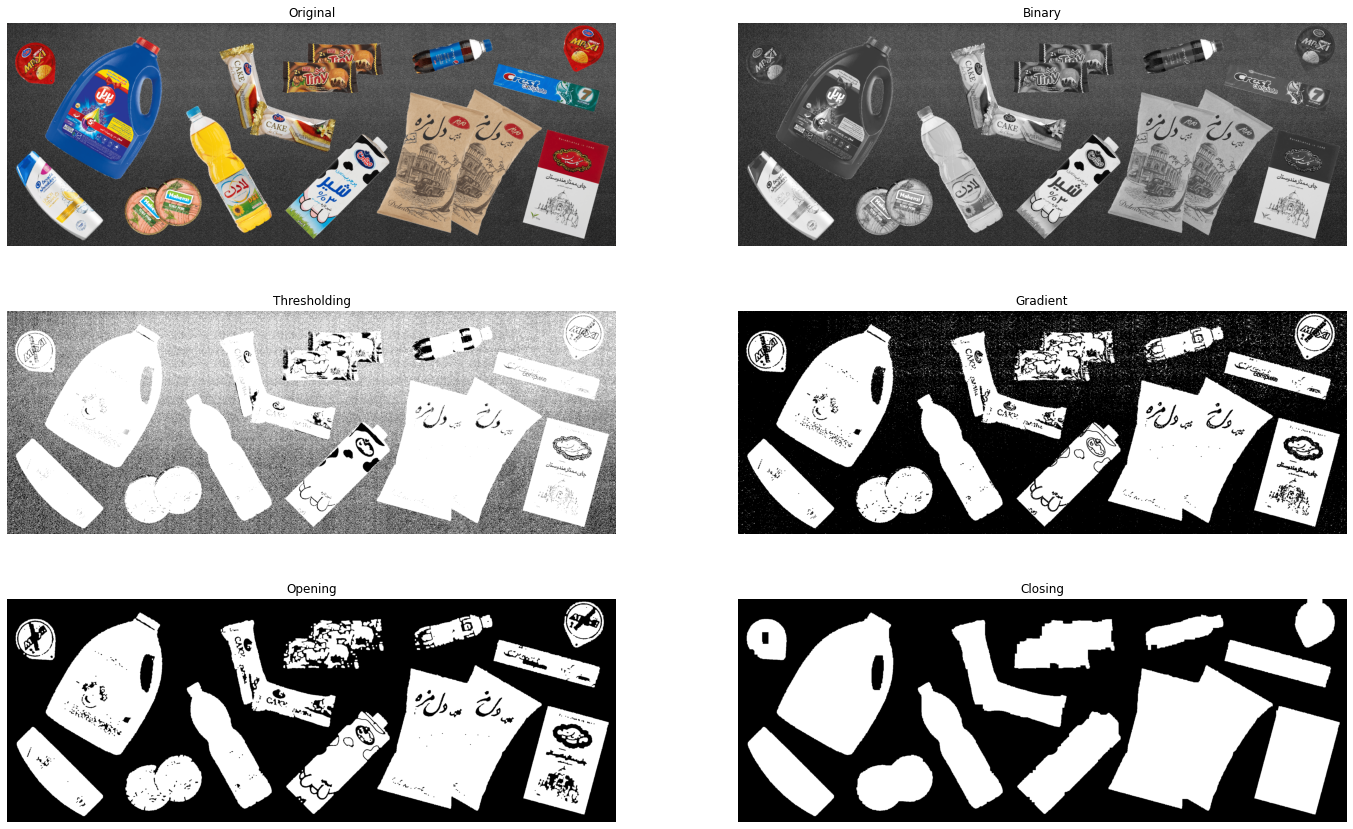

In [976]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 3))
org_img = images[1]
org_img = org_img[50:-50,]
binary = cv2.cvtColor(org_img, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(binary, 50, 255, cv2.THRESH_BINARY)


gradient1 = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
gradient1 = np.subtract(gradient1, np.ones(gradient1.shape, np.uint8))


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 7))
opening1 = cv2.morphologyEx(gradient1, cv2.MORPH_OPEN, kernel)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 45))

closing1 = cv2.morphologyEx(opening1, cv2.MORPH_CLOSE, kernel)
closing1 = np.multiply(np.subtract(closing1, 254), 255)

plotter([org_img, binary, thresh, gradient1, opening1, closing1], ['Original', 'Binary', 'Thresholding', 'Gradient', 'Opening', 'Closing'], subplots=(3, 2), gray=True)

In [942]:
contours, hierarchy = cv2.findContours(closing1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
total_cnt = len(contours)
print('The count of items on the conveyor belt:  {}'.format(total_cnt))

The count of items on the conveyor belt:  13


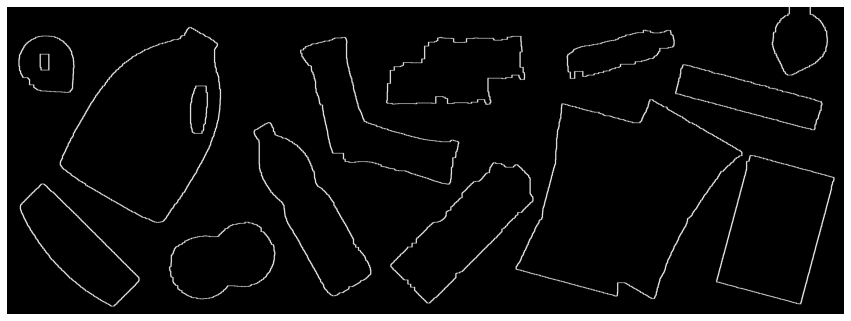

In [943]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 2))

gradient = get_gradient(closing1, kernel)
gradient = get_gradient(gradient, kernel)
plotter(gradient, gray=True)

In [968]:
items = {0: 'Makenzi', 1: 'Shampoo', 2: 'Milk', 3: 'Tea', 4: 'Oil', 5: 'Chips', 6: 'Toothpaste',
         7: 'Mihan cake', 8: 'Tiny cake', 9: 'Maxi', 10: 'Pepci', 11: 'Peril', 12: 'Maxi'}

In [969]:
result = {}
for key,value in items.items():
    if value not in result.values():
        result[key] = value
items = result
items

{0: 'Makenzi',
 1: 'Shampoo',
 2: 'Milk',
 3: 'Tea',
 4: 'Oil',
 5: 'Chips',
 6: 'Toothpaste',
 7: 'Mihan cake',
 8: 'Tiny cake',
 9: 'Maxi',
 10: 'Pepci',
 11: 'Peril'}

The count of   Makenzi     :  1
The count of   Shampoo     :  0
The count of   Milk        :  1
The count of   Tea         :  1
The count of   Oil         :  0
The count of   Chips       :  1
The count of   Toothpaste  :  0
The count of   Mihan cake  :  1
The count of   Tiny cake   :  1
The count of   Maxi        :  1
The count of   Pepci       :  1
The count of   Peril       :  0


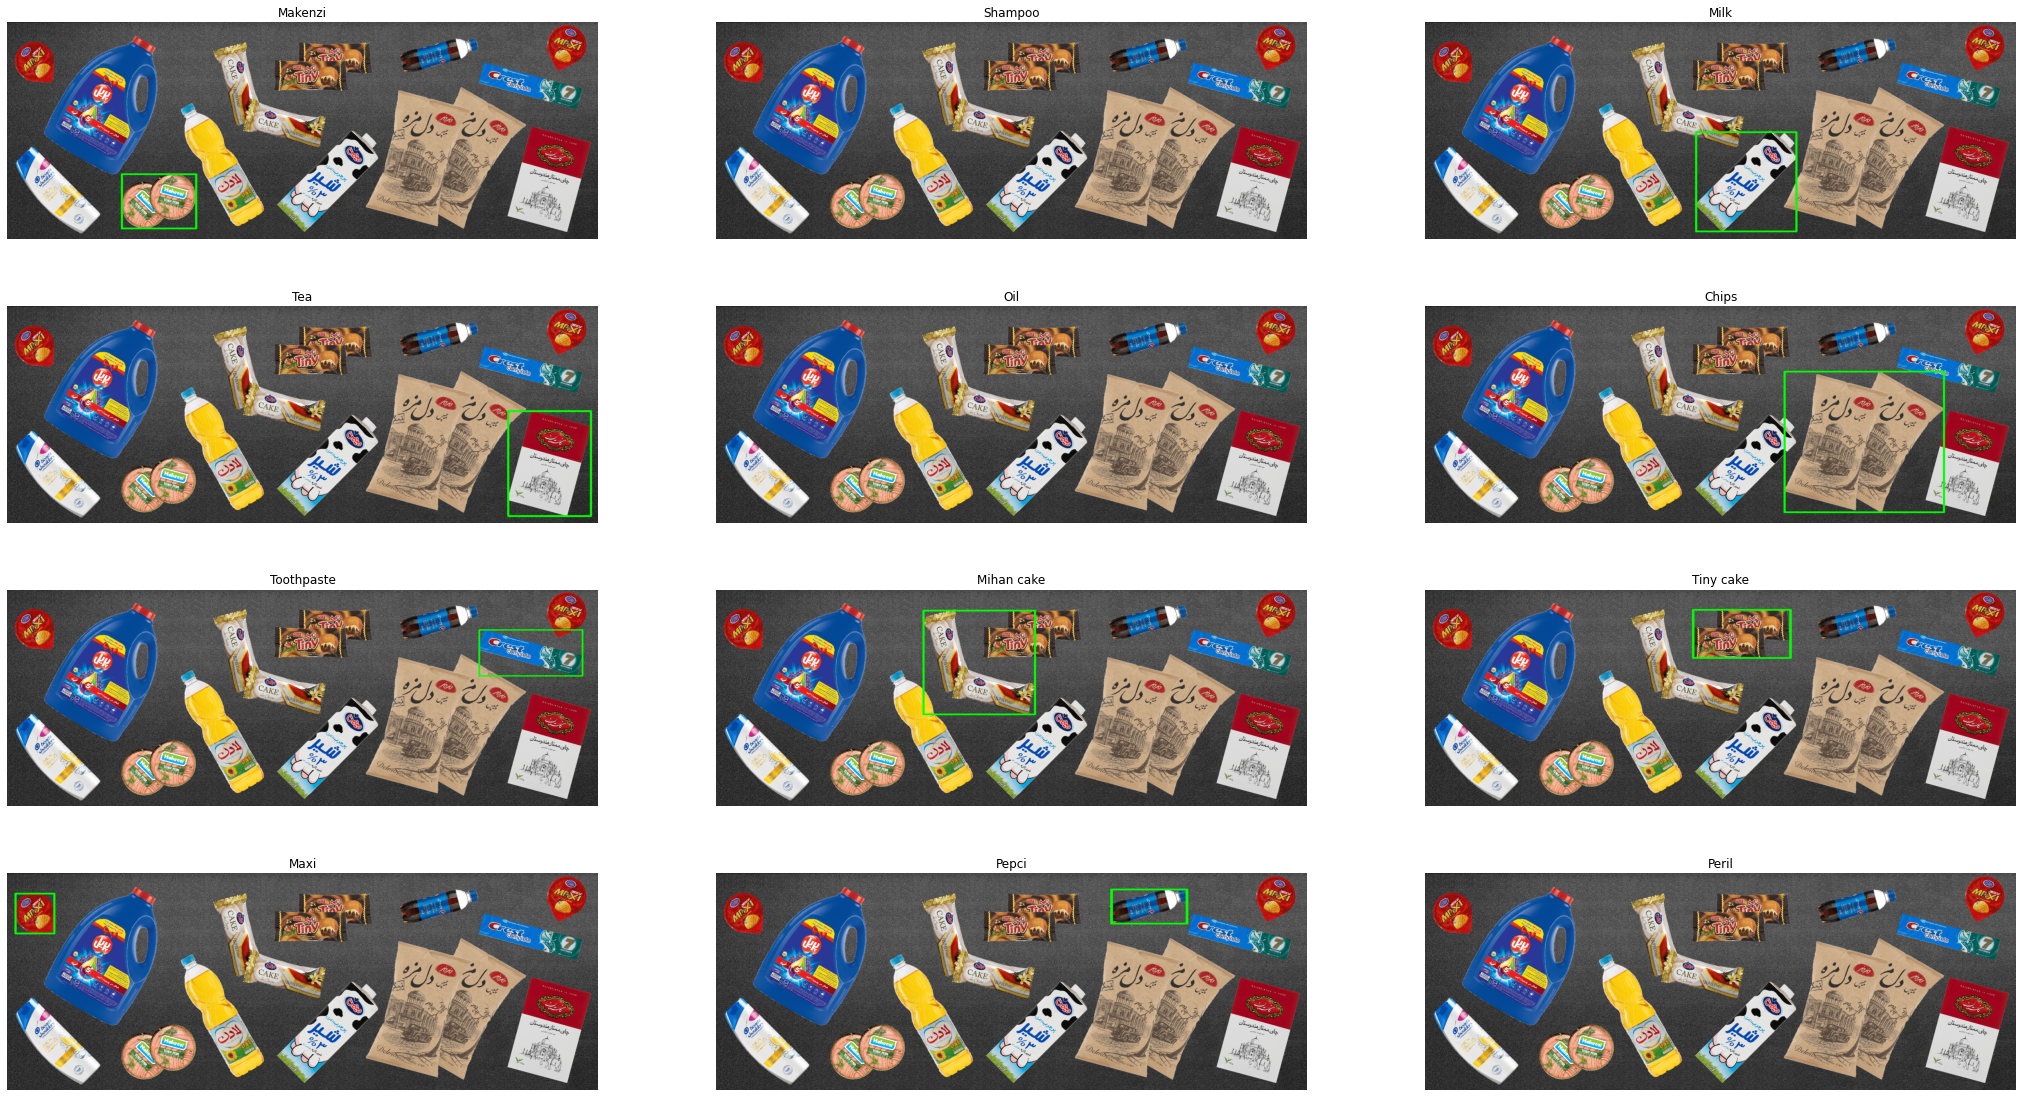

In [972]:
results = []
for key, value in zip(list(items.keys()), list(items.values())):
    results.append(find_objects(contours=contours, item=(key, value), search_in_img=gradient.copy(), org_img=org_img.copy(), total_cnt=total_cnt)[0])
plotter(results, names=items.values(), subplots=(4, 3))